# Pytorch starter - FasterRCNN Inference

- You can find the [train notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)
- The weights are [available here](https://www.kaggle.com/dataset/7d5f1ed9454c848ecb909c109c6fa8e573ea4de299e249c79edc6f47660bf4c5)

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/pytorch-starter-fasterrcnn-train'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn2.pth'

In [2]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])


In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [8]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [9]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


In [10]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9976 558 533 120 185 0.9956 69 2 100 159 0.9937 28 457 101 156 0.9929 332 668 111 144 0.9919 741 772 78 116 0.9915 615 919 80 98 0.9884 690 392 118 165 0.9877 592 784 89 109 0.9874 818 708 106 201 0.9873 178 569 108 189 0.9863 245 90 128 140 0.9850 359 537 93 80 0.9799 459 862 80 95 0.9631 306 1 73 65 0.9583 238 847 147 89 0.9531 536 38 153 213 0.9266 93 620 113 86 0.9112 67 858 109 69 0.8786 357 257 113 155 0.8666 823 920 124 102 0.8494 825 634 84 112 0.7320 166 5 76 144 0.5476 335 895 65 67 0.5128 808 541 86 110'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9919 611 93 157 170 0.9914 843 265 129 201 0.9886 508 473 195 106 0.9880 772 883 145 102 0.9871 274 474 135 111 0.9831 65 690 128 214 0.9804 807 765 101 91 0.9788 819 93 106 80 0.9721 31 0 82 71 0.9703 188 923 113 100 0.9655 349 136 97 179 0.9647 568 600 113 116 0.9598 697 920 83 87 0.9383 660 582 107 92 0.9216 247 119 106 119 0.9211 655 791 98 81 0.9173 1 381 54 111 0.9

In [11]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9976 558 533 120 185 0.9956 69 2 100 159 0.9...
1,51f1be19e,0.9919 611 93 157 170 0.9914 843 265 129 201 0...
2,f5a1f0358,0.9944 941 431 82 185 0.9942 543 271 110 113 0...
3,796707dd7,0.9919 942 75 81 99 0.9918 897 334 110 90 0.98...
4,51b3e36ab,0.9977 538 35 251 127 0.9967 233 647 95 157 0....


In [12]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

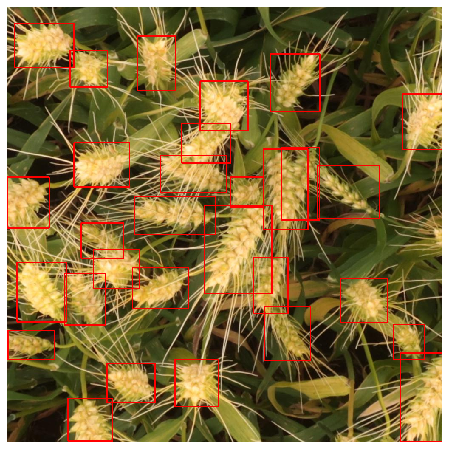

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [14]:
test_df.to_csv('submission.csv', index=False)